In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch

class RBM(nn.Module):
    def __init__(self,
                 n_visible=256,
                 n_hidden=64):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.Tensor(n_hidden,n_visible).uniform_(-1.0/(n_visible+n_hidden), 1.0/(n_visible+n_hidden)))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
    
    def sample_from_p(self,p):
        return torch.bernoulli(p)
    
    def v_to_h(self,v):
#         print(21212121212)
        # p_h = F.sigmoid(v.mm(self.W.t()) + self.h_bias.repeat(v.size()[0],1))
#         print(self.v_bias.shape)
#         print(self.h_bias.shape)
#         print(v.shape)
#         print(F.linear(v,self.W,self.h_bias).shape)
#         print(self.W.shape)
        X_prob = torch.matmul(v,self.W.t())
        X_prob = torch.add(X_prob, self.h_bias)#W.x + c
        if n_hidden == 30:
          p_h = F.relu(X_prob, inplace=False)
        else:
          p_h = torch.sigmoid(X_prob)
        
#         print(333333333)
        sample_h = self.sample_from_p(p_h)
#         print(444444444)
        return p_h,sample_h
    
    def h_to_v(self,h):
        X_prob = F.linear(h,self.W.t(),self.v_bias)
        if n_hidden == 30:
          p_v = F.relu(X_prob, inplace=False)
        else:
          p_v = torch.sigmoid(X_prob)
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v, CD_k = 10):
#         print(v.shape)
#         print(222222222)
        pre_h1,h1 = self.v_to_h(v)
#         print(pre_h1.shape)
#         print(h1.shape)
        h_ = h1
        for _ in range(CD_k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = torch.clamp(F.linear(v,self.W,self.h_bias),-80,80)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
      
    def reconstruct(self , X,n_gibbs):
        '''
        This will reconstruct the sample with k steps of gibbs Sampling
        '''
        v = X
        for i in range(n_gibbs):
            prob_h_,h = self.v_to_h(v)
            prob_v_,v = self.h_to_v(prob_h_)
        return prob_v_,v
      
    def reconstruction_error(self, input_data,
                                n_gibbs_sampling_steps=1,lr = 0.001):
        # positive phase

        positive_hidden_probabilities,positive_hidden_act  = self.h_to_v(input_data)

        # calculating W via positive side
        positive_associations = torch.matmul(input_data.t() , positive_hidden_act)


        # negetive phase
        hidden_activations = positive_hidden_act
        for i in range(n_gibbs_sampling_steps):
            visible_probabilities , _ = self.v_to_h(hidden_activations)
            hidden_probabilities,hidden_activations = self.h_to_v(visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        # calculating W via negative side
        negative_associations = torch.matmul(negative_visible_probabilities.t() , negative_hidden_probabilities)


        # Compute reconstruction error
        error = torch.mean(torch.sum((input_data - negative_visible_probabilities)**2 , dim = 0))

        return error,torch.sum(torch.abs(grad_update))


In [0]:
class DBN(nn.Module):
    def __init__(self,
                 n_visible=784,
                 n_hidden=[23*23 ,18*18],):
        super(DBN, self).__init__()
        
        self.n_layers = len(n_hidden)
        self.rbm_layers = []
        
        for i in range(self.n_layers):
            if i == 0:
                input_size = n_visible
            else:
                input_size = n_hidden[i-1]
            rbm = RBM(n_visible = input_size, n_hidden = n_hidden[i])
            
            self.rbm_layers.append(rbm)
        
        self.W_rec = [nn.Parameter(self.rbm_layers[i].W.data.clone()) for i in range(self.n_layers-1)]
        self.W_gen = [nn.Parameter(self.rbm_layers[i].W.data) for i in range(self.n_layers-1)]
        self.bias_rec = [nn.Parameter(self.rbm_layers[i].h_bias.data.clone()) for i in range(self.n_layers-1)]
        self.bias_gen = [nn.Parameter(self.rbm_layers[i].v_bias.data) for i in range(self.n_layers-1)]
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)
        
        for i in range(self.n_layers-1):
            self.register_parameter('W_rec%i'%i, self.W_rec[i])
            self.register_parameter('W_gen%i'%i, self.W_gen[i])
            self.register_parameter('bias_rec%i'%i, self.bias_rec[i])
            self.register_parameter('bias_gen%i'%i, self.bias_gen[i])
        
        
    def forward(self, v_input, ith_layer, CD_k = 10): #for greedy training
        v = v_input
        
        for ith in range(ith_layer):
            p_v, v = self.rbm_layers[ith].v_to_h(v)
            
        v, v_ = self.rbm_layers[ith_layer](v, CD_k = CD_k)

        return v, v_
      
    def reconstruct(self,input_data):
      '''
      go till the final layer and then reconstruct
      '''
      h = input_data
      p_h = 0
      for i in range(len(self.rbm_layers)):
          h = h.view((h.shape[0] , -1)).type(torch.FloatTensor)#flatten
          p_h,h = self.rbm_layers[i].v_to_h(h)

      v = h
      for i in range(len(self.rbm_layers)-1,-1,-1):
          v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)
          p_v,v = self.rbm_layers[i].h_to_v(v)
      return p_v,v

The number shown is the number: 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


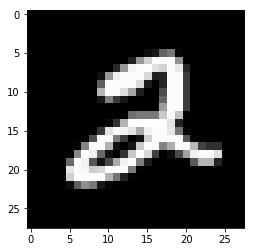

In [0]:
import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np

batch_size = 8

# convert each image to tensor format
transform = transforms.Compose([
    transforms.ToTensor()  # convert to tensor
])



mnist_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [0]:
import torch
import torch.autograd as autograd
import numpy as np
import torch.utils.data
from torch import optim
from torch.autograd import Variable
from joblib import Parallel, delayed
import multiprocessing
import torch.nn as nn
import torch.nn.functional as F


# optimizer = optim.Adam(dbn_mnist.parameters(), lr=1e-3)

# loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

lr = 0.1
epoch = 10
batch_size = 8
input_data = mnist_data
weight_decay = 0
L1_penalty = 0
CD_k = 10
test_set = test_data
initialize_v = False

n_hidden=[784,1000,300,30,300,1000,784]

dbn = DBN(n_hidden=n_hidden)
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

# train_set = torch.utils.data.dataset.TensorDataset(input_data, torch.zeros(input_data.size()[0]))
# train_loader = torch.utils.data.DataLoader(input_data, batch_size = batch_size, shuffle=True)
loss_function = nn.MSELoss()
loss_list = []

for i in range(dbn.n_layers):
  print(dbn.n_layers)
  print("Training the %ith layer"%int(i+1))
  optimizer = optim.SGD(dbn.rbm_layers[i].parameters(), lr = lr, weight_decay = weight_decay)
  if initialize_v:
    v = Variable(input_data)
    for ith in range(i):
        p_v, v = dbn.rbm_layers[ith].v_to_h(v)
    dbn.rbm_layers[i].v_bias.data.zero_()
    dbn.rbm_layers[i].v_bias.data.add_(torch.log(v.mean(0)/(1-v.mean(0))).data)
  for _ in range(epoch):
    total_loss = 0
    print(_)
    for batch_idx, (data, target) in enumerate(train_loader):
#       data.view(data.size(0), -1)
      if batch_idx % 100 == 0:
        print("_",batch_idx,end = "")
      data = data.view((data.shape[0] , -1)).type(torch.FloatTensor)
#       print(data.shape)
      v, v_ = dbn(v_input = data, ith_layer = i, CD_k = CD_k)
      _, redata =  dbn.reconstruct(data)
#       loss = dbn.rbm_layers[i].free_energy(v.detach()) - dbn.rbm_layers[i].free_energy(v_.detach()) + L1_penalty * torch.sum(torch.abs(dbn.rbm_layers[i].W))
      loss = loss_function(redata, data)
      total_loss += loss.item()
#       print(total_loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
    print("\nepoch: ", _, total_loss)
    if i == dbn.n_layers -1:
      loss_list.append(total_loss)
    

  
  
#       print(redata[0])
#       org_imgs.append(data[0])
#       regen_imgs.append(redata[0])
#       print(type(redata))
#       if batch_idx % 1000 == 0:
#         print("______",batch_idx,"_",loss_function(redata, data),'_',loss, end = "")
#       mse += loss
#       count += 1
#     mse /= float(count)
#     print("\nepoch %i: "%i," MSE: ", mse)
#     torg = torch.zeros(len(org_imgs),org_imgs[0].shape[0],org_imgs[0].shape[1]).cuda()
#     rorg = torch.zeros(len(org_imgs),org_imgs[0].shape[0],org_imgs[0].shape[1]).cuda()
#     org_imgs = torch.Tensor(org_imgs)
#     regen_imgs = torch.Tensor(regen_imgs)
    
#     i = 0
#     for img in org_imgs:
#       torg[i] = img
#       i += 1
#     i = 0
#     for img in regen_imgs:
#       rorg[i] = img
#       i += 1
#     print()
#     print(loss_function(regen_imgs, org_imgs))
    
#     org_imgs = []
#     regen_imgs = []
#     print("epoch %i: "%i," Training loss: ",loss)
#     if not type(test_set) == type(None):
      
#       print("epoch %i: "%i, loss_function(dbn.reconstruct(input_data), test_set))

7
Training the 1th layer
0
_ 0_ 100_ 200_ 300_ 400_ 500_ 600_ 700_ 800_ 900_ 1000_ 1100_ 1200_ 1300_ 1400_ 1500_ 1600_ 1700_ 1800_ 1900_ 2000_ 2100_ 2200_ 2300_ 2400_ 2500_ 2600_ 2700_ 2800_ 2900_ 3000_ 3100_ 3200_ 3300_ 3400_ 3500_ 3600_ 3700_ 3800_ 3900_ 4000_ 4100_ 4200_ 4300_ 4400_ 4500_ 4600_ 4700_ 4800_ 4900_ 5000_ 5100_ 5200_ 5300_ 5400_ 5500_ 5600_ 5700_ 5800_ 5900_ 6000_ 6100_ 6200_ 6300_ 6400_ 6500_ 6600_ 6700_ 6800_ 6900_ 7000_ 7100_ 7200_ 7300_ 7400
epoch:  tensor([[0.4969, 0.5003, 0.4972,  ..., 0.5010, 0.5006, 0.5019],
        [0.4967, 0.5000, 0.4994,  ..., 0.4990, 0.5002, 0.5007],
        [0.4963, 0.4998, 0.5005,  ..., 0.4977, 0.4985, 0.5027],
        ...,
        [0.4965, 0.5003, 0.4983,  ..., 0.5013, 0.4999, 0.5019],
        [0.4978, 0.5007, 0.4981,  ..., 0.5014, 0.4984, 0.5028],
        [0.4980, 0.4975, 0.5007,  ..., 0.5014, 0.4982, 0.5018]],
       grad_fn=<SigmoidBackward>) 3609.6565956771374
1
_ 0_ 100_ 200_ 300_ 400_ 500_ 600_ 700_ 800_ 900_ 1000_ 1100_ 1200_ 1300_

KeyboardInterrupt: ignored